## Traffic flow simulation

Continuity Equation:
$$ 
\frac{\partial{}}{\partial{t}} \rho(x,t) = - \frac{\partial{}}{\partial{x}} F(\rho(x,t))
$$
where $ F(\rho) = \rho(x,t) v(\rho(x,t))$, and $ v(\rho) = v_m(1- \frac{\rho}{\rho_m}) $, where the subscript $m$ denotes the maximum value of the variable.

Traffic is initially stationary at a traffic light, $\rho = \rho_{max}$. Light goes green, first car is free to move at $v_{max}$ as density is zero ahead of the car. Last car can only move when the density there decreases from $\rho_{max}$ and traffic is no longer bumper to bumper. There is a discontinuity (shock front) at the rear of the last car and this moves as the last car moves. Basic example of a rarefaction wave problem.

We use periodic BCs, IC is a square pulse.

In [11]:
import numpy as np 
import matplotlib.pyplot as plt 

## Basic System w/ Sqr Pulse IC

Suggested time step is:  0.2
last car starts moving in 20.0 steps


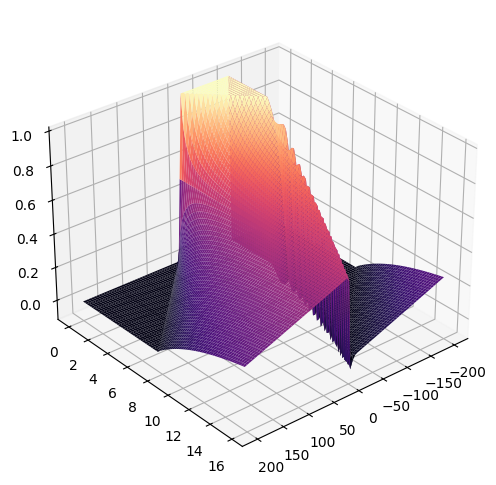

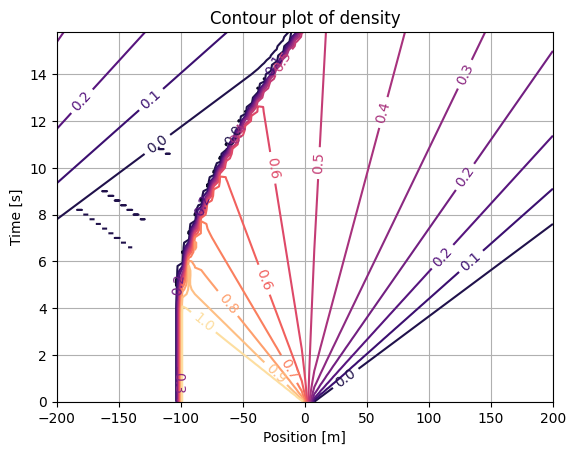

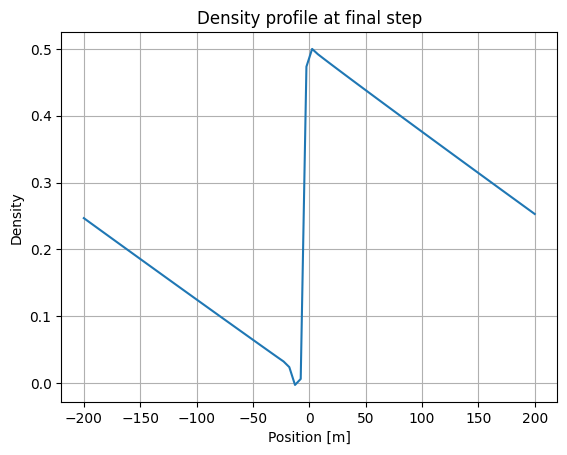

In [14]:
# Paramaters 
tau = 0.2 
N = 80      # no. of grid points 
L = 400.     # metres 
h = L/N     # grid spacing, not N-1 as were using periodic BCs 
x = np.linspace(0, L, N) - (L/2)
time = 0
Method = 'LW'       # 'FTCS', 'Lax', 'LW'
coeff = tau/(2*h)
coeff_lw = tau**2/(2*h**2)
vmax = 25       # m/s
print('Suggested time step is: ', h/vmax)
print(f'last car starts moving in {(L/4)/(vmax*tau)} steps')
nsteps = 80

# ICs
rho = np.zeros(N)
rhoMax = 1.          # normalised max density
for i in range(int(N/4), int(N/2)):
    rho[i] = rhoMax         # IC is sqr pulse from x = -L/4 to 0
rho[int(N/2)] = rhoMax/2
F = np.zeros(N)     # flux
cr = np.empty(nsteps)
cl = np.empty(nsteps)

# Periodic BCs
idx_r = np.arange(N) +1       # i+1
idx_r[N-1] = 0
idx_l =  np.arange(N) -1    # i-1
idx_l[0] = N-1

# Plotting params 
rhoPlot = np.empty((nsteps, N))
tPlot = np.empty(nsteps)
xPlot = x
plotCount = 1

rhoPlot[0,:] = np.copy(rho)
tPlot[0] = 0

# Main Loop
for i in range(1,nsteps): 
    time += tau 

    # initalise Flux space derivatives
    F[:] = rho[:] * (vmax*(1 - (rho[:]/rhoMax)))

    if Method == 'FTCS':
        rho[:] = rho[:] - coeff*(F[idx_r] - F[idx_l])

    if Method == 'Lax':
        rho[:] = 0.5*(rho[idx_r] + rho[idx_l]) - coeff*(F[idx_r] - F[idx_l])
    
    if Method == 'LW':
        r_ip = (rho[idx_r] + rho[:])        # factor of 2 cancels
        r_im = (rho[idx_l] + rho[:])
        cr = vmax*(1-(r_ip/rhoMax))
        cl = vmax*(1-(r_im/rhoMax))
        rho[:] = rho[:] - coeff*(F[idx_r] - F[idx_l]) + coeff_lw*(cr*(F[idx_r] - F[:]) - cl*(F[:] - F[idx_l]))
        
    

    # save for plotting
    rhoPlot[i, :] = np.copy(rho) 
    tPlot[i] = np.copy(time)


from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(9,6))
xp, tp = np.meshgrid(xPlot, tPlot)
ax.plot_surface(xp, tp, rhoPlot, cmap=cm.magma, rstride=1, cstride=1)
ax.view_init(azim=50, elev=30)
plt.show()

# contour plot:
ct = plt.contour(xPlot, tPlot,rhoPlot, levels=16, cmap=cm.magma)
plt.xlabel('Position [m]')
plt.ylabel('Time [s]')
plt.clabel(ct, fmt='%1.1f', fontsize=10)
plt.title('Contour plot of density')
plt.grid()
plt.show()

# final density profile
plt.plot(xPlot, rhoPlot[-1,:])
plt.xlabel('Position [m]'); plt.ylabel('Density')
plt.grid()
plt.title('Density profile at final step')
plt.show()


When running the simulation for longer than the time taken for one 'wave' to reach the final car, we can see the migration of the 'shock front' - the discontinuity which marks the position of the last car. Since the BCs are periodic, eg cars going around a racetrack, the density becomes non-zero again left of the shock. $\rho(x,t)$ is multivalued at the shock as lines of high denisty and low (mostly zero) density intersect.
The expansion fan is also clealy shown. 

We expect density to vary linearly with position besides at the discontinuities as velocity is a linear function of density. This is not observed in the FTCS method despite the result appearing stable.

Lax shows better characteristics, but the slope of the decrease is too fast and the left edge is not maintained.

Lax-Wendroff is the only accurate scheme for longer simulations, FTCS and Lax become unstable (though Lax still represents general correct profile, where FTCS fails completely).

## Excerise (11):
(a) Show that the IC:
$$ \rho(x,t=0) = \frac{\rho_m}{2} [1 + cos(4 \pi x/L)]$$
- Turns into a sawtooth wave

(b) Compute spatial power spectrum of the density.


Suggested time step is:  0.2
last car starts moving in 20.0 steps
The Nyquist frequency is 2.5


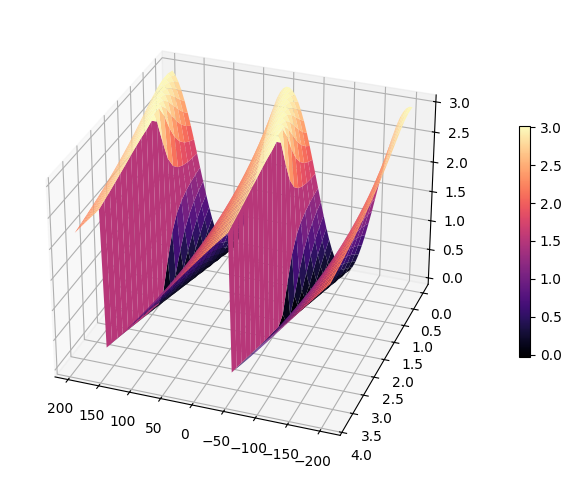

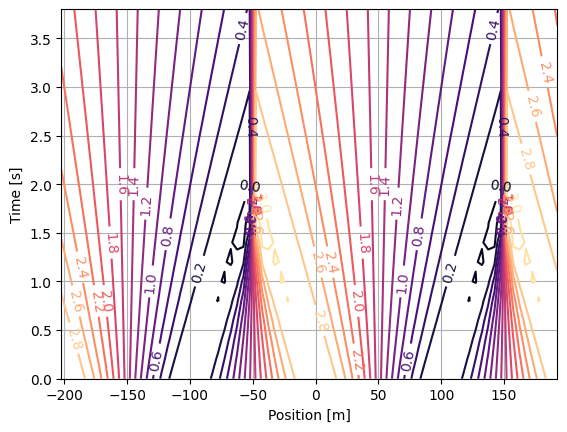

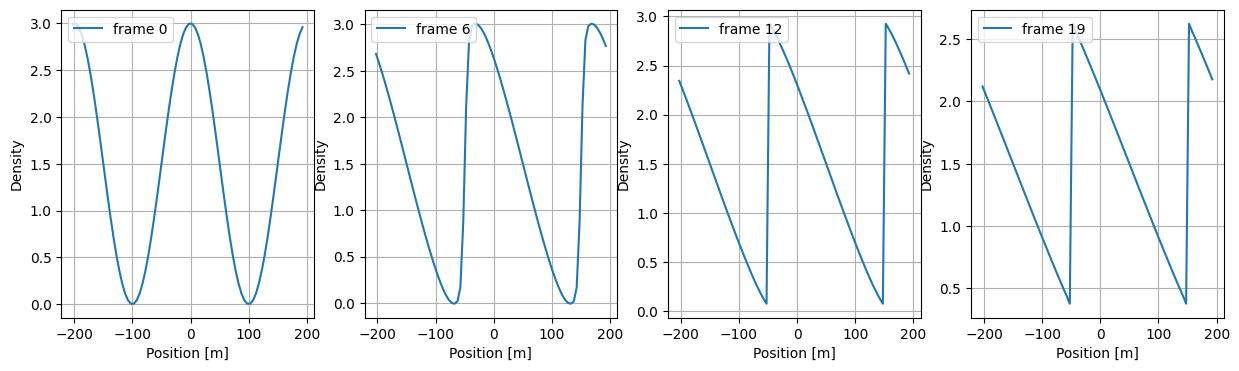

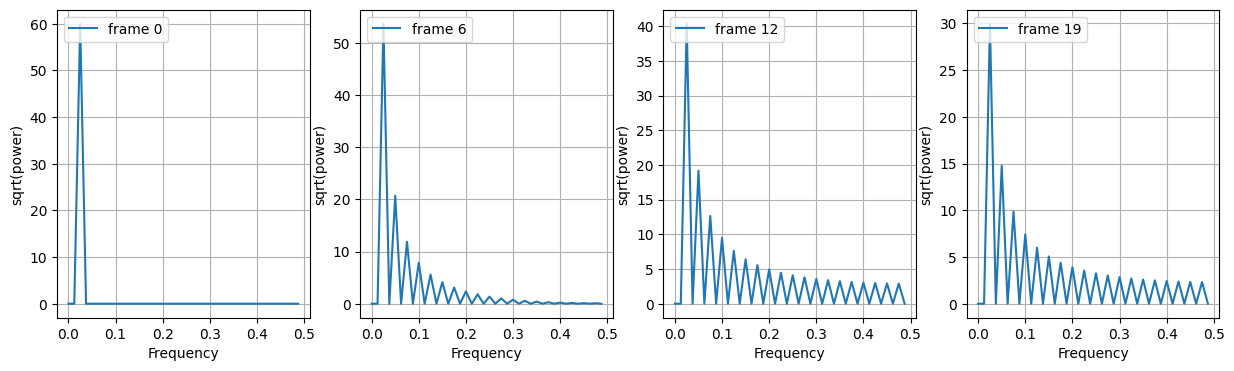

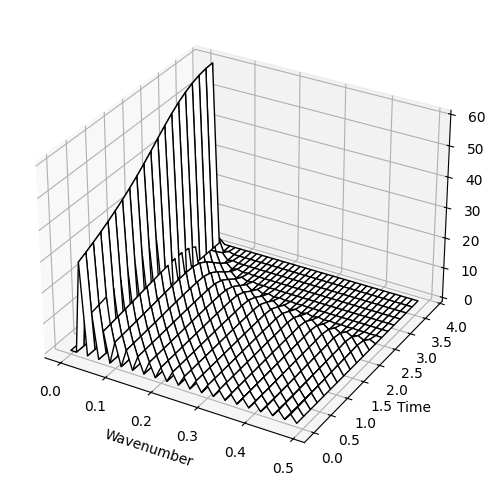

In [5]:
# Paramaters 
tau = 0.2 
N = 80      # no. of grid points 
L = 400.     # metres 
h = L/N     # grid spacing, not N-1 as were using periodic BCs 
x = (np.arange(N)-1/2)*h -L/2
time = 0
Method = 'LW'       # 'FTCS', 'Lax', 'LW'
coeff = tau/(2*h)
coeff_lw = tau**2/(2*h**2)
vmax = 25       # m/s
print('Suggested time step is: ', h/vmax)
print(f'last car starts moving in {(L/4)/(vmax*tau)} steps')
nsteps = 20
f_ny = 1/(2*tau)
print(f'The Nyquist frequency is {f_ny}')
f = np.arange(0, N, 1)/N

# ICs
rho = np.zeros(N)
rhoMax = 3.          # normalised max density
rho_IC = (rhoMax/2) * (1 + np.cos(4*np.pi*x/L))
rho[:] = rho_IC
F = np.zeros(N)     # flux
cr = np.empty(nsteps)
cl = np.empty(nsteps)
rho_FT = np.fft.fft(rho)
rho_PS = rho_FT * np.conj(rho_FT)
rho_PS[0] = 0

# Periodic BCs
idx_r = np.arange(N) +1       # i+1
idx_r[N-1] = 0
idx_l =  np.arange(N) -1    # i-1
idx_l[0] = N-1

# Plotting params 
rhoPlot = np.empty((nsteps, N))
tPlot = np.empty(nsteps)
xPlot = x
plotCount = 1
plots = 4
plotstep = nsteps/plots
PS_plot = np.empty((nsteps, N))

rhoPlot[0,:] = np.copy(rho)
tPlot[0] = 0
PS_plot[0,:] = np.sqrt(np.copy(np.real(rho_PS)))



# Main Loop
for i in range(1,nsteps): 
    time += tau 

    # initalise Flux space derivatives
    F[:] = rho[:] * (vmax*(1 - (rho[:]/rhoMax)))

    if Method == 'FTCS':
        rho[:] = rho[:] - coeff*(F[idx_r] - F[idx_l])

    if Method == 'Lax':
        rho[:] = 0.5*(rho[idx_r] + rho[idx_l]) - coeff*(F[idx_r] - F[idx_l])
    
    if Method == 'LW':
        r_ip = (rho[idx_r] + rho[:])        # factor of 2 cancels
        r_im = (rho[idx_l] + rho[:])
        cr = vmax*(1-(r_ip/rhoMax))
        cl = vmax*(1-(r_im/rhoMax))
        rho[:] = rho[:] - coeff*(F[idx_r] - F[idx_l]) + coeff_lw*(cr*(F[idx_r] - F[:]) - cl*(F[:] - F[idx_l]))

    rho_FT = np.fft.fft(rho)
    rho_PS = rho_FT * np.conj(rho_FT)
    rho_PS[0] = 0           # remove first wavenumber (otherwise overpowers plot)
    

    # save for plotting
    rhoPlot[i, :] = np.copy(rho) 
    tPlot[i] = np.copy(time)
    PS_plot[i,:] = np.sqrt(np.copy(np.real(rho_PS)))


from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(12,6))
xp, tp = np.meshgrid(xPlot, tPlot)
surf = ax.plot_surface(xp, tp, rhoPlot, rstride=1, cstride=1, cmap=cm.magma)
ax.view_init(azim=110, elev=30)
plt.colorbar(surf, shrink=0.5)
plt.show()

# contour plot:
ct = plt.contour(xPlot, tPlot, rhoPlot, levels=16,  cmap=cm.magma)
plt.xlabel('Position [m]')
plt.ylabel('Time [s]')
plt.clabel(ct, fmt='%1.1f', fontsize=10)
plt.grid()
# plt.colorbar(None, shrink=0.75)
plt.show()

# final density profile
steps = np.array([0,6,12,19])
fig, ax = plt.subplots(1,4, figsize=(15,4))
for j,i in enumerate(steps):
    ax[j].plot(xPlot, rhoPlot[int(i),:], label=f'frame {i:.0f}')
    ax[j].grid()
    ax[j].legend(loc='upper left')
    ax[j].set_xlabel('Position [m]'); ax[j].set_ylabel('Density')
plt.show()

# Power Spectrum frames
steps = np.array([0,6,12,19])
fig, ax = plt.subplots(1,4, figsize=(15,4))
for j,i in enumerate(steps):
    ax[j].plot(f[0:int(N/2)], PS_plot[i,0:int(N/2)], label=f'frame {i:.0f}')
    ax[j].grid()
    ax[j].legend(loc='upper left')
    ax[j].set_xlabel('Frequency'); ax[j].set_ylabel('sqrt(power)')
plt.show()

# Power Spectrum contour plot
fig, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(12,6))
fp, tp = np.meshgrid(f[0:int(N/2)], np.flip(tPlot))
ax.plot_surface(fp, tp, PS_plot[:,0:int(N/2)], rstride=1, cstride=1, edgecolor='k', facecolor='w')
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Time')
# ax.view_init(azim=110, elev=30)
plt.show()


- We start with a pure cosine wave, the power spectrum shows almost all energy is in a single wavenumber.
- Nonlinear effects disort the cosine wave - formation of N-/sawtooth waves.
- Results in more high-frequency components in the spectrum.
- The spread of energy into higher wavenumbers shows how nonlinear distortion generates harmonics
- The formation of these N-waves demonstrates how non-linearity leads to discontinuity/shock formation.